In [203]:
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm.keras import TqdmCallback 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import metrics
from sklearn.preprocessing import OneHotEncoder

# Players with Minutes Only

In [281]:
X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')
Y_test =  pd.read_csv('data/Y_test.csv')

In [283]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_test.drop(columns=['Unnamed: 0'], inplace=True)

# Make Baseline

In [284]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

# Defining loss functions
def MSE(true_values, predicted_values):
    """Return the MSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

def RMSE(true_values, predicted_values):
    """Return the RMSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the RMSE
    return math.sqrt(tot / len(true_values))

def MAE(true_values, predicted_values):
    """Return the MAE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += abs(true_values[count] - predicted_values[count])
        count += 1
    
    # Returning the MAE
    return tot / len(true_values)

In [285]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()
true = np.array(Y_train['total_points'])
pred = np.array(pred_vect(Y_train['total_points'],baseline))

print(f'MSE is {round(MSE(true, pred),3)}')
print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 6.303
RMSE is 2.511
MAE is 1.664


# First Attempt at RNN

In [286]:
X_train.columns

Index(['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind',
       'position', 'GW', 'was_home', 'name_normalized', 'assists_lag_1',
       'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1', 'creativity_lag_1',
       'goals_conceded_lag_1', 'goals_scored_lag_1', 'ict_index_lag_1',
       'influence_lag_1', 'minutes_lag_1', 'own_goals_lag_1',
       'penalties_missed_lag_1', 'penalties_saved_lag_1', 'red_cards_lag_1',
       'saves_lag_1', 'selected_lag_1', 'player_team_score_lag_1',
       'opp_team_score_lag_1', 'threat_lag_1', 'total_points_lag_1',
       'value_lag_1', 'yellow_cards_lag_1', 'assists_lag_3', 'bonus_lag_3',
       'bps_lag_3', 'clean_sheets_lag_3', 'creativity_lag_3',
       'goals_conceded_lag_3', 'goals_scored_lag_3', 'ict_index_lag_3',
       'influence_lag_3', 'minutes_lag_3', 'own_goals_lag_3',
       'penalties_missed_lag_3', 'penalties_saved_lag_3', 'red_cards_lag_3',
       'saves_lag_3', 'selected_lag_3', 'player_team_score_lag_3',
       'opp_team_

In [287]:
X_train.head()

,season,player_team_name,opp_team_name,opp_diff_ind,position,GW,was_home,name_normalized,assists_lag_1,bonus_lag_1,...,penalties_saved_lag_5,red_cards_lag_5,saves_lag_5,selected_lag_5,player_team_score_lag_5,opp_team_score_lag_5,threat_lag_5,total_points_lag_5,value_lag_5,yellow_cards_lag_5
0,2018-19,West Ham,Liverpool,4,DEF,1,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.409936,-1.808301,-1.899736,-0.529878,-0.752585,-3.373454,-0.430582
1,2018-19,West Ham,Bournemouth,1,DEF,2,True,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.155985,-1.808301,3.816565,-0.529878,-0.752585,0.329490,-0.430582
2,2018-19,West Ham,Arsenal,4,DEF,3,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.170799,-1.121215,2.387490,-0.529878,-0.752585,0.329490,-0.430582
3,2018-19,West Ham,Wolves,2,DEF,4,True,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.193770,-0.892187,2.387490,-0.529878,-0.752585,0.307048,-0.430582
4,2018-19,West Ham,Everton,2,DEF,5,False,aaron cresswell,-0.184964,-0.215403,...,-0.048352,-0.093734,-0.177503,-0.212392,-1.121215,1.672952,-0.529878,-0.611039,0.278995,1.677694


In [288]:
# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

In [289]:
def one_hot_encode_categorical(train_df, val_df, categorical_vars):
    for var in categorical_vars:
        # Fit the encoder on the training set and transform both training and validation sets
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        train_column = train_df[[var]]
        val_column = val_df[[var]]

        # Fit and transform training set
        encoded_train = encoder.fit_transform(train_column)
        encoded_train_df = pd.DataFrame(encoded_train, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        train_df = pd.concat([train_df, encoded_train_df], axis=1)

        # Transform validation set, handle unknown categories
        encoded_val = encoder.transform(val_column)
        encoded_val_df = pd.DataFrame(encoded_val, columns=[f'{var}_{cat}' for cat in encoder.get_feature_names_out([var])])
        val_df = pd.concat([val_df, encoded_val_df], axis=1)

        train_df = train_df.drop([var], axis=1)
        val_df = val_df.drop([var], axis=1)

    return train_df, val_df
cat_vars_non_sequence = ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home', 'season']

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)

## Sequence Slicing

In [290]:
X_train.head()

,assists_lag_1,bonus_lag_1,bps_lag_1,clean_sheets_lag_1,creativity_lag_1,goals_conceded_lag_1,goals_scored_lag_1,ict_index_lag_1,influence_lag_1,minutes_lag_1,...,GW_GW_34,GW_GW_35,GW_GW_36,GW_GW_37,GW_GW_38,was_home_was_home_False,was_home_was_home_True,season_season_2018-19,season_season_2019-20,season_season_2020-21
0,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.184964,-0.215403,-0.606985,-0.337274,-0.437810,-0.508046,-0.188555,-0.562091,-0.555264,-0.785924,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.184964,-0.215403,0.433488,-0.337274,2.172931,0.540089,-0.188555,0.665147,0.214342,1.437098,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [291]:
# Example function to create sequences and align targets
def create_sequences_and_targets(X, Y, sequence_length):
    sequences = []
    targets = []

    for player_id, group in X.groupby('player_id'):
        player_targets = Y[Y['player_id'] == player_id]['total_points']

        for start_idx in range(len(group) - sequence_length + 1):
            end_idx = start_idx + sequence_length
            sequences.append(group.iloc[start_idx:end_idx].values)
            targets.append(player_targets.iloc[end_idx - 1])  # Aligning target

    return np.array(sequences), np.array(targets)

# Create sequences and aligned targets
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


In [292]:
X_train_sequences.shape

(66612, 3, 168)

## Test Model

In [295]:
def plot_history():
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    # Define custom colors for better visualization
    colors = {
        'train_loss': '#1f77b4',
        'val_loss': '#ff7f0e',
        'train_mse': '#FFA500',
        'val_mse': '#d62728',
        'train_mae': '#9467bd',
        'val_mae': '#8c564b'
    }
    
    # Create a figure with subplots
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(13, 5))
    
    # Plot Training and Validation Loss
    ax1.plot(x_arr, hist['loss'], '-o', color=colors['train_loss'], label='Train Loss')
    ax1.plot(x_arr, hist['val_loss'], '--<', color=colors['val_loss'], label='Validation Loss')
    ax1.legend(fontsize=12)
    ax1.set_xlabel('Epoch', size=12)
    ax1.set_ylabel('Loss', size=12)
    ax1.set_title('Loss by Epoch', size=14)
    ax1.axhline(y=MSE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot Training and Validation MAE
    ax3.plot(x_arr, hist['mae'], '-o', color=colors['train_mae'], label='Train MAE')
    ax3.plot(x_arr, hist['val_mae'], '--<', color=colors['val_mae'], label='Validation MAE')
    ax3.legend(fontsize=12)
    ax3.set_xlabel('Epoch', size=12)
    ax3.set_ylabel('MAE', size=12)
    ax3.set_title('MAE by Epoch', size=14)
    ax3.axhline(y=MAE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [294]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

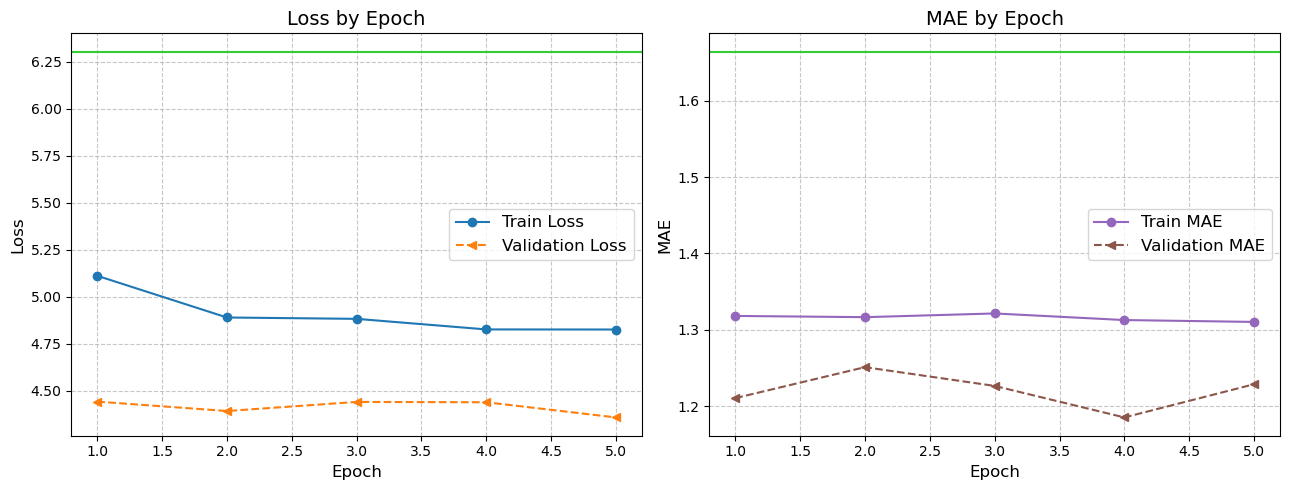

In [296]:
plot_history()

In [120]:
def plot_history():
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    # Define custom colors for better visualization
    colors = {
        'train_loss': '#1f77b4',
        'val_loss': '#ff7f0e',
        'train_mse': '#FFA500',
        'val_mse': '#d62728',
        'train_mae': '#9467bd',
        'val_mae': '#8c564b'
    }
    
    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    # Plot Training and Validation Loss
    ax1.plot(x_arr, hist['loss'], '-o', color=colors['train_loss'], label='Train Loss')
    ax1.plot(x_arr, hist['val_loss'], '--<', color=colors['val_loss'], label='Validation Loss')
    ax1.legend(fontsize=12)
    ax1.set_xlabel('Epoch', size=12)
    ax1.set_ylabel('Loss', size=12)
    ax1.set_title('Loss by Epoch', size=14)
    ax1.axhline(y=MSE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot Training and Validation MSE
    ax2.plot(x_arr, hist['mse'], '-o', color=colors['train_mse'], label='Train MSE')
    ax2.plot(x_arr, hist['val_mse'], '--<', color=colors['val_mse'], label='Validation MSE')
    ax2.legend(fontsize=12)
    ax2.set_xlabel('Epoch', size=12)
    ax2.set_ylabel('MSE', size=12)
    ax2.set_title('MSE by Epoch', size=14)
    ax2.axhline(y=MSE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Plot Training and Validation MAE
    ax3.plot(x_arr, hist['mae'], '-o', color=colors['train_mae'], label='Train MAE')
    ax3.plot(x_arr, hist['val_mae'], '--<', color=colors['val_mae'], label='Validation MAE')
    ax3.legend(fontsize=12)
    ax3.set_xlabel('Epoch', size=12)
    ax3.set_ylabel('MAE', size=12)
    ax3.set_title('MAE by Epoch', size=14)
    ax3.axhline(y=MAE(true, pred), color='limegreen', linestyle='-', label='MSE(true, pred)')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

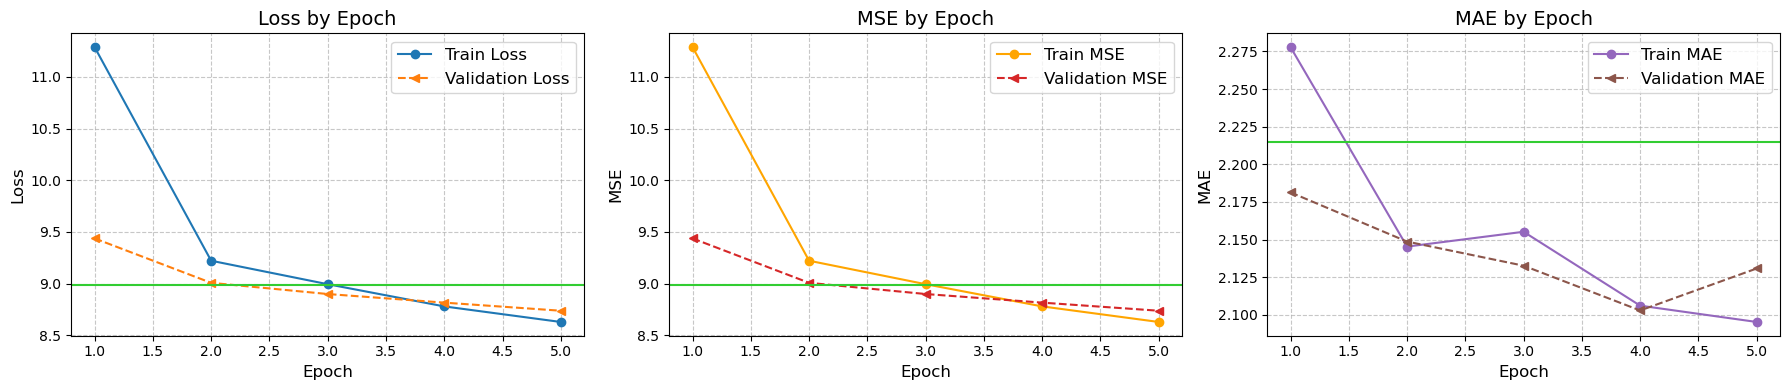

In [103]:
plot_history()

# All Players

In [270]:
X_train = pd.read_csv('data/feat_eng/alpha-StandardScaling-X_train-minutes_players.csv')
Y_train = pd.read_csv('data/feat_eng/alpha-StandardScaling-Y_train-minutes_players.csv')
X_val = pd.read_csv('data/feat_eng/alpha-StandardScaling-X_val-minutes_players.csv')
Y_val = pd.read_csv('data/feat_eng/alpha-StandardScaling-Y_val-minutes_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

cat_vars_non_sequence = ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home']

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)

X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(29856, 3, 174)

In [271]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [272]:
baseline

1.3593784070590629

In [273]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()
true = np.array(Y_train['total_points'])
pred = np.array(pred_vect(Y_train['total_points'],baseline))

print(f'MSE is {round(MSE(true, pred),3)}')
print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 8.987
RMSE is 2.998
MAE is 2.215


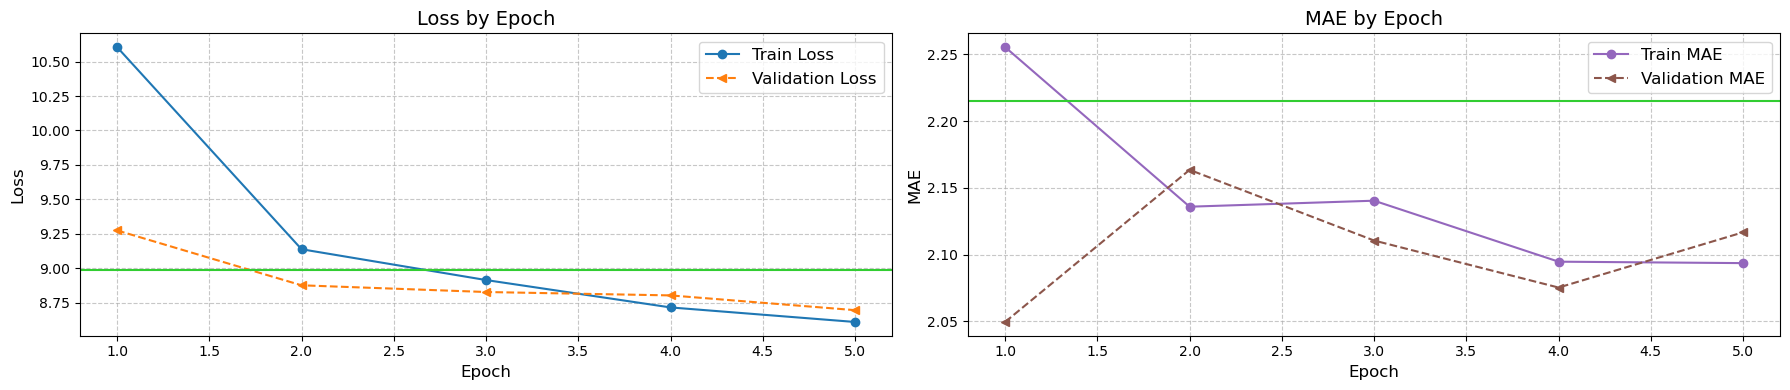

In [274]:
plot_history()

# Using Different Scalings

### RobustScaler

In [122]:
X_train = pd.read_csv('data/feat_eng/alpha-RobustScaler-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/alpha-RobustScaler-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/alpha-RobustScaler-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/alpha-RobustScaler-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(66612, 3, 174)

In [123]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

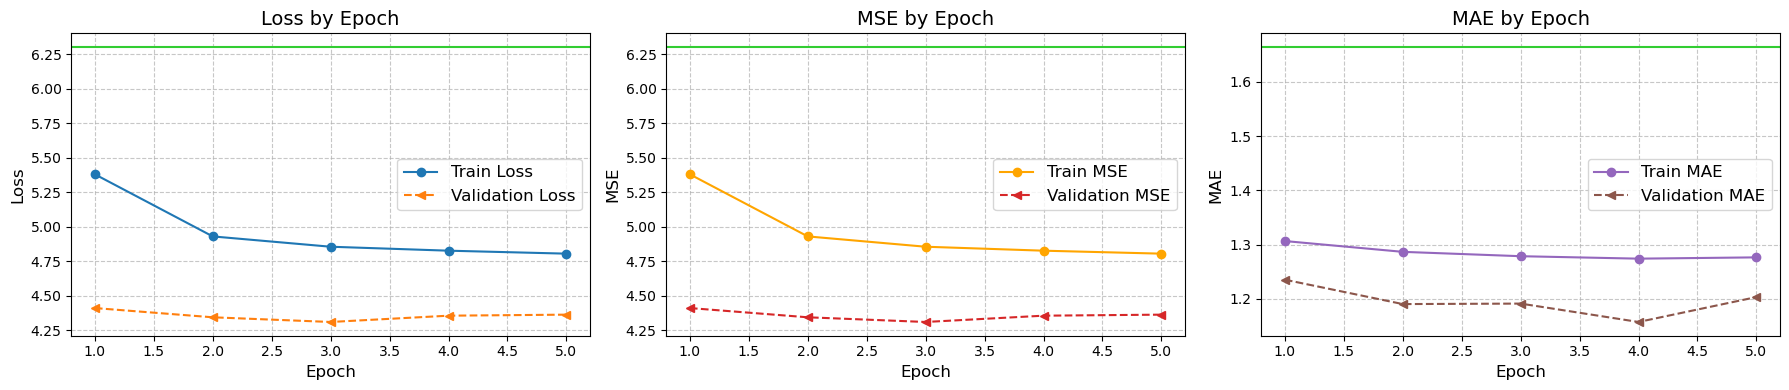

In [124]:
plot_history()

### MinMaxScaler

In [126]:
X_train = pd.read_csv('data/feat_eng/alpha-MinMaxScaler-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/alpha-MinMaxScaler-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/alpha-MinMaxScaler-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/alpha-MinMaxScaler-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(66612, 3, 174)

In [127]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

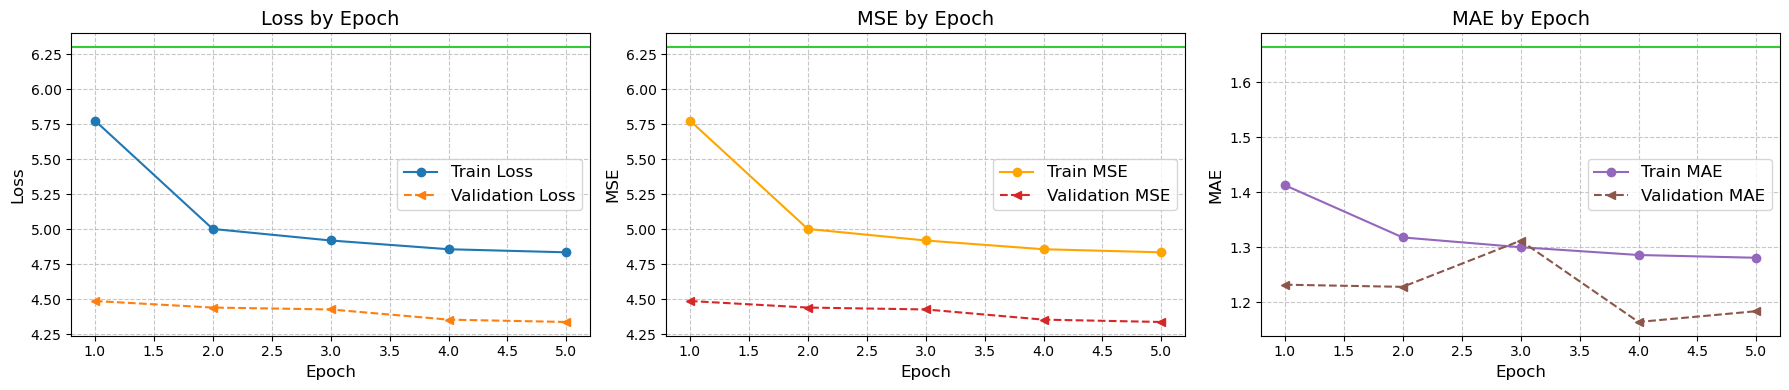

In [128]:
plot_history()

# Testing different Validation Splits

### Beta Split

In [131]:
X_train = pd.read_csv('data/feat_eng/beta-StandardScaler-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/beta-StandardScaler-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/beta-StandardScaler-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/beta-StandardScaler-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(45079, 3, 170)

In [132]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

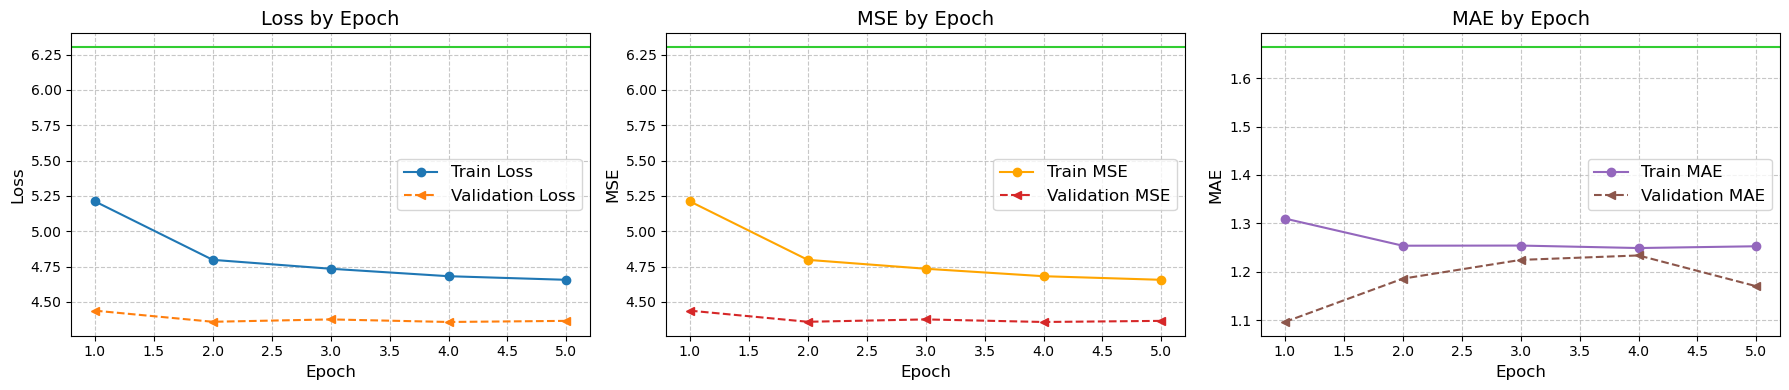

In [133]:
plot_history()

### Theta Split

In [134]:
X_train = pd.read_csv('data/feat_eng/theta-StandardScaler-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/theta-StandardScaler-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/theta-StandardScaler-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/theta-StandardScaler-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(70079, 3, 172)

In [135]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

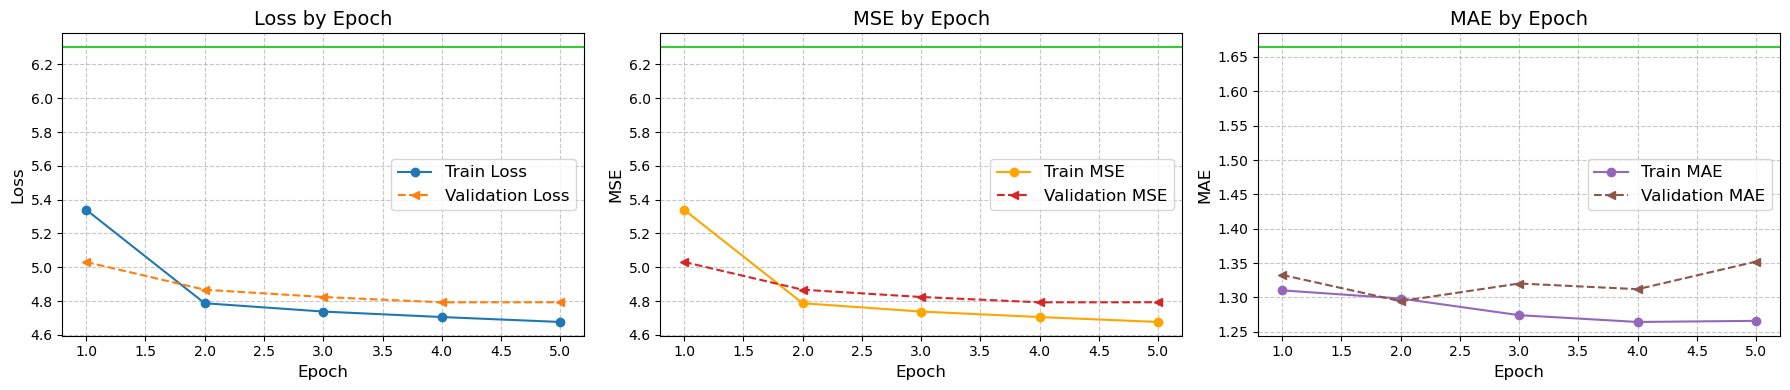

In [136]:
plot_history()

### Gamma Split

In [138]:
X_train = pd.read_csv('data/feat_eng/gamma-StandardScaler-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/gamma-StandardScaler-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/gamma-StandardScaler-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/gamma-StandardScaler-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)
X_train_sequences, Y_train_aligned = create_sequences_and_targets(X_train, Y_train, 3)
X_val_sequences, Y_val_aligned = create_sequences_and_targets(X_val, Y_val, 3)


X_train_sequences.shape

(47848, 3, 161)

In [139]:
# LSTM Base model

sequence_length = X_train_sequences.shape[1]
num_features = X_train_sequences.shape[2]
model = Sequential()
model.add(LSTM(3, 
               return_sequences=False, 
               input_shape=(sequence_length, num_features),
               name='LSTM'
              ),
         )
# Adding a Dropout layer for regularization
model.add(Dropout(0.2, name='drop'))

# Final Output layer (1 for regression task)
model.add(Dense(
        units=1,
        activation='linear',
        name='Dense1'
    ))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
history = model.fit(X_train_sequences, Y_train_aligned, epochs=5, batch_size=32, 
                    validation_data = (X_val_sequences, Y_val_aligned),
                   callbacks=[TqdmCallback()], verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

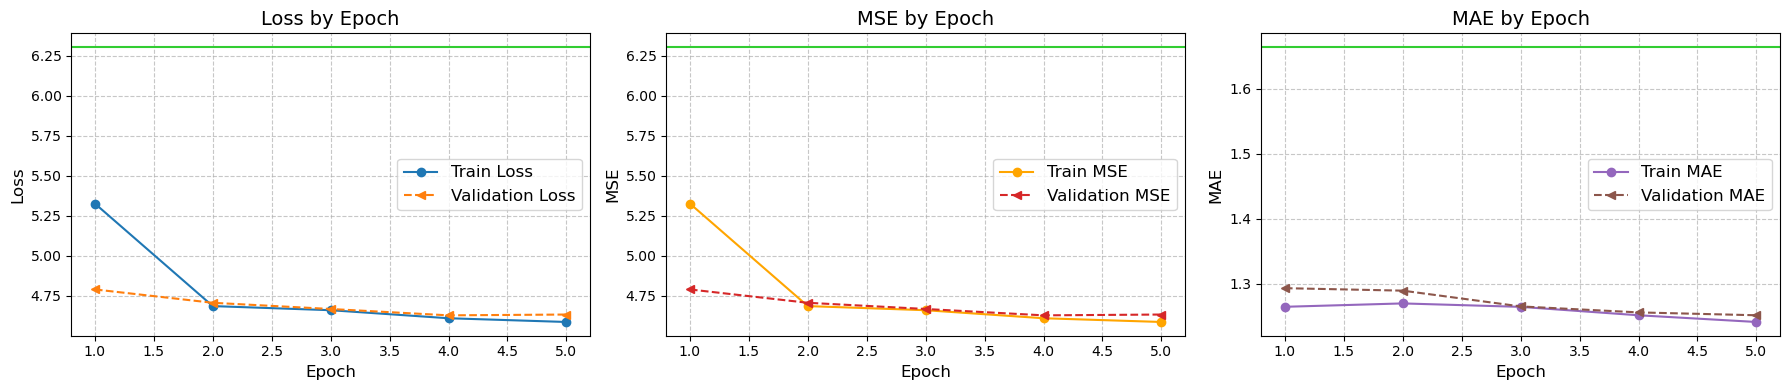

In [140]:
plot_history()

# Hypter Tuning the All Player Data Based on 

In [141]:
X_train = pd.read_csv('data/feat_eng/alpha-StandardScaling-X_train-all_players.csv')
Y_train = pd.read_csv('data/feat_eng/alpha-StandardScaling-Y_train-all_players.csv')
X_val = pd.read_csv('data/feat_eng/alpha-StandardScaling-X_val-all_players.csv')
Y_val = pd.read_csv('data/feat_eng/alpha-StandardScaling-Y_val-all_players.csv')

X_train.drop(columns=['Unnamed: 0'], inplace=True)
Y_train.drop(columns=['Unnamed: 0'], inplace=True)
X_val.drop(columns=['Unnamed: 0'], inplace=True)
Y_val.drop(columns=['Unnamed: 0'], inplace=True)

# Assuming df is your DataFrame and 'name_normalized' is the column with player names
X_train['player_id'] = pd.factorize(X_train['name_normalized'])[0]
X_val['player_id'] = pd.factorize(X_val['name_normalized'])[0]
# Now, 'player_id' is a numeric representation of 'name_normalized'
Y_train['player_id'] = pd.factorize(Y_train['name_normalized'])[0]
Y_val['player_id'] = pd.factorize(Y_val['name_normalized'])[0]

X_train.drop('name_normalized', axis=1, inplace=True)
X_val.drop('name_normalized', axis=1, inplace=True)
Y_train.drop('name_normalized', axis=1, inplace=True)
Y_val.drop('name_normalized', axis=1, inplace=True)

X_train.drop('sequence', axis=1, inplace=True)
X_val.drop('sequence', axis=1, inplace=True)

X_train, X_val = one_hot_encode_categorical(X_train, X_val, cat_vars_non_sequence)

In [142]:
all_cols = X_train.columns

cats_prefix = ('player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home')

categorical_cols = [col for col in X_train.columns if col.startswith(cats_prefix)]


lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [182]:
cont_settings = {
    'all': [lag_1, lag_3, lag_5],
    'one': [lag_1],
    'three': [lag_3],
    'five': [lag_5],
}
cat_settings = {
    'nil': [],
    'all': ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home'],
    'basic': ['was_home', 'position'],
    'base_team_opp': ['was_home', 'position', 'player_team_name', 'opp_team_name'],
    'base_team_opp_diff': ['was_home', 'position', 'player_team_name', 'opp_team_name', 'opp_diff_ind'],
}

In [183]:
def col_and_seq_pipeline(x_train, y_train, x_val, y_val, cat, cont, seq_len):
    def select_columns(df, categorical_prefixes, continuous_sets):
    # Select categorical columns based on prefixes
        categorical_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in categorical_prefixes)]
        
        # Select continuous columns based on specified sets
        continuous_cols = ['player_id']
        for continuous_set in continuous_sets:
            continuous_cols.extend(continuous_set)
        
    
        # Combine selected categorical and continuous columns
        selected_cols = categorical_cols + continuous_cols
        return df[selected_cols]
    train_feat_reduced = select_columns(x_train, cat, cont)
    val_feat_reduced = select_columns(x_val, cat, cont)
    x_t, y_t = create_sequences_and_targets(train_feat_reduced, y_train, seq_len)
    x_v, y_v = create_sequences_and_targets(val_feat_reduced, y_val, seq_len)
    return x_t, y_t, x_v, y_v

In [184]:
def compile_and_run(train_seq, y_train_seq, val_seq, y_val_seq, **kwargs):
    print(f"Training model with setting: {kwargs}")
    sequence_length = train_seq.shape[1]
    num_features = train_seq.shape[2]
    lstm_size = kwargs.get('lstm_size', 50)
    epochs = kwargs.get('epochs', 1)    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    dropout_rate = kwargs.get('dropout_rate', 0.5)

    model = Sequential([
        LSTM(lstm_size, return_sequences=True, input_shape=(sequence_length, num_features), name='LSTM1'),
        Dropout(dropout_rate, name='drop1'),
        LSTM(lstm_size, return_sequences=True, name='LSTM2'),
        Dropout(dropout_rate, name='drop2'),
        LSTM(lstm_size, return_sequences=False, name='LSTM3'),
        Dropout(dropout_rate, name='drop3'),
        Dense(units=1, activation='linear', name='Dense1')
    ])
    lr = kwargs.get("learning_rate", 0.001)
    if kwargs.get('optimizer') != 'SGD': 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    print(f"Training model with learning rate: {lr}")
    history = model.fit(train_seq, y_train_seq, epochs=epochs, batch_size=kwargs.get('batch_size',32), 
                        validation_data=(val_seq, y_val_seq), verbose=0, callbacks=[TqdmCallback()])

    hist = history.history
    seq_length = kwargs.get('seq_length', 3)

    new_row = {'contin_set': kwargs.get('con_key'), 'categ_key': kwargs.get('cat_key'), 'learning_rate': lr, 
             'lstm_size': lstm_size, 'lstm_layers': 3, 'seq_length': seq_length,
               'optimizer': kwargs.get('optimizer', 'Adam'), 'dropout_rate': dropout_rate, 'batch_size': kwargs.get('batch_size',32),
               'train_loss': hist['loss'][-1], 'train_rmse': hist['root_mean_squared_error'][-1],
               'train_mae': hist['mean_absolute_error'][-1], 
               'val_loss': hist['val_loss'][-1], 'val_rmse': hist['val_root_mean_squared_error'][-1],
               'val_mae': hist['val_mean_absolute_error'][-1]}
    results_one.loc[len(results_one)] = new_row

In [185]:
# {'loss': [6.478851795196533, 5.442587375640869], 
#  'mean_squared_error': [6.478851795196533, 5.442587375640869], 
#  'root_mean_squared_error': [2.545358896255493, 2.332935333251953], 
#  'mean_absolute_error': [1.526414394378662, 1.4166772365570068],
#  'val_loss': [5.185041904449463, 4.745915412902832], 
#  'val_mean_squared_error': [5.185041904449463, 4.745915412902832], 
#  'val_root_mean_squared_error': [2.277068614959717, 2.1785120964050293], 
#  'val_mean_absolute_error': [1.3986597061157227, 1.3201528787612915]}

In [187]:
results_one = pd.DataFrame(columns=['contin_set', 'categ_key', 'learning_rate', 'lstm_size', 'lstm_layers', 'seq_length',
                    'optimizer', 'dropout_rate', 'batch_size','train_loss', 'train_rmse', 'train_mae','val_loss','val_rmse', 'val_mae'])
s=3
lstms = [s, s*4]
for lstm_size in lstms:
    for con_key, con_val in cont_settings.items():
        for cat_key, cat_val in cat_settings.items(): 
            for lr in [0.01, 0.001, 0.0001]:
                for dropout_rate in [0, 0.2, 0.5]:
                    for batch_size in [32, 128]:
                        train_seq, y_train_seq, val_seq, y_val_seq = col_and_seq_pipeline(
                            X_train, Y_train, X_val, Y_val, cat_val, con_val, s
                        )
                        compile_and_run(
                            train_seq, y_train_seq, val_seq, y_val_seq, 
                            seq_length=s, lstm_size=lstm_size, 
                            cat_key=cat_key, con_key=con_key, 
                            learning_rate=lr, dropout_rate=dropout_rate,
                            batch_size=batch_size
                        )

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}
Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}
Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}
Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}
Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}
Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}
Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'one', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'three', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'nil', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'all', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'basic', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.01


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 32}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training model with setting: {'seq_length': 3, 'lstm_size': 12, 'cat_key': 'base_team_opp_diff', 'con_key': 'five', 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'batch_size': 128}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [189]:
results_one.lstm_size.value_counts()

lstm_size
3     360
12    360
Name: count, dtype: int64

In [190]:
results_one.lstm_layers.value_counts()

lstm_layers
3    720
Name: count, dtype: int64

In [195]:
results_one.sort_values(by='train_loss',ascending=True).head(20)

,contin_set,categ_key,learning_rate,lstm_size,lstm_layers,seq_length,optimizer,dropout_rate,batch_size,train_loss,train_rmse,train_mae,val_loss,val_rmse,val_mae
397,all,basic,0.010,12,3,3,Adam,0.0,128,4.889900,2.211312,1.298403,4.429762,2.104700,1.159110
379,all,all,0.010,12,3,3,Adam,0.0,128,4.891150,2.211595,1.290681,4.441910,2.107584,1.183483
361,all,nil,0.010,12,3,3,Adam,0.0,128,4.894049,2.212250,1.293496,4.473629,2.115095,1.122793
384,all,all,0.001,12,3,3,Adam,0.0,32,4.894968,2.212457,1.277769,4.378241,2.092425,1.081574
415,all,base_team_opp,0.010,12,3,3,Adam,0.0,128,4.900906,2.213799,1.293669,4.423594,2.103234,1.150295
433,all,base_team_opp_diff,0.010,12,3,3,Adam,0.0,128,4.912538,2.216424,1.296350,4.445136,2.108349,1.223588
504,one,base_team_opp,0.010,12,3,3,Adam,0.0,32,4.932692,2.220966,1.307198,4.569870,2.137725,1.147957
469,one,all,0.010,12,3,3,Adam,0.0,128,4.938179,2.222202,1.306644,4.411830,2.100436,1.134160
505,one,base_team_opp,0.010,12,3,3,Adam,0.0,128,4.940692,2.222767,1.301891,4.590299,2.142498,1.220140
396,all,basic,0.010,12,3,3,Adam,0.0,32,4.944680,2.223664,1.307845,4.558440,2.135050,1.130611


In [192]:
results_one.sort_values(by='val_loss',ascending=True).head(20)

,contin_set,categ_key,learning_rate,lstm_size,lstm_layers,seq_length,optimizer,dropout_rate,batch_size,train_loss,train_rmse,train_mae,val_loss,val_rmse,val_mae
384,all,all,0.001,12,3,3,Adam,0.0,32,4.894968,2.212457,1.277769,4.378241,2.092425,1.081574
420,all,base_team_opp,0.001,12,3,3,Adam,0.0,32,4.951128,2.225113,1.297150,4.383285,2.093630,1.148942
386,all,all,0.001,12,3,3,Adam,0.2,32,5.063844,2.250299,1.317402,4.400372,2.097706,1.142099
438,all,base_team_opp_diff,0.001,12,3,3,Adam,0.0,32,4.951851,2.225276,1.301791,4.403391,2.098426,1.164237
440,all,base_team_opp_diff,0.001,12,3,3,Adam,0.2,32,5.099360,2.258176,1.319029,4.407356,2.099370,1.131771
528,one,base_team_opp_diff,0.001,12,3,3,Adam,0.0,32,4.964312,2.228074,1.310358,4.408239,2.099581,1.111202
469,one,all,0.010,12,3,3,Adam,0.0,128,4.938179,2.222202,1.306644,4.411830,2.100436,1.134160
404,all,basic,0.001,12,3,3,Adam,0.2,32,5.090271,2.256163,1.328921,4.415847,2.101392,1.173037
422,all,base_team_opp,0.001,12,3,3,Adam,0.2,32,5.086064,2.255230,1.325609,4.416850,2.101630,1.166571
402,all,basic,0.001,12,3,3,Adam,0.0,32,4.987178,2.233199,1.313214,4.421243,2.102675,1.105034


In [193]:
results_one.sort_values(by='train_loss',ascending=True).tail(20)

,contin_set,categ_key,learning_rate,lstm_size,lstm_layers,seq_length,optimizer,dropout_rate,batch_size,train_loss,train_rmse,train_mae,val_loss,val_rmse,val_mae
121,one,all,0.0001,3,3,3,Adam,0.0,128,8.007932,2.829829,1.387030,7.127935,2.669819,1.282452
177,one,base_team_opp_diff,0.0001,3,3,3,Adam,0.2,128,8.010238,2.830236,1.388342,7.176221,2.678847,1.277472
215,three,all,0.0001,3,3,3,Adam,0.5,128,8.011251,2.830415,1.394686,7.140945,2.672255,1.281375
355,five,base_team_opp_diff,0.0001,3,3,3,Adam,0.0,128,8.015174,2.831108,1.392082,7.152562,2.674427,1.279739
143,one,basic,0.0001,3,3,3,Adam,0.5,128,8.015373,2.831143,1.421837,7.059711,2.657012,1.285522
87,all,base_team_opp_diff,0.0001,3,3,3,Adam,0.2,128,8.015577,2.831179,1.386219,7.185545,2.680587,1.275172
357,five,base_team_opp_diff,0.0001,3,3,3,Adam,0.2,128,8.025886,2.832999,1.385776,7.207526,2.684684,1.273399
15,all,nil,0.0001,3,3,3,Adam,0.2,128,8.029322,2.833606,1.385842,7.214582,2.685997,1.273176
213,three,all,0.0001,3,3,3,Adam,0.2,128,8.032379,2.834145,1.411035,7.026590,2.650772,1.291526
125,one,all,0.0001,3,3,3,Adam,0.5,128,8.037086,2.834975,1.386425,7.246226,2.691882,1.270419


In [167]:
r1 = results_one.copy()

In [ ]:
# Refined Architecture Based on Level 1 Results

In [166]:
cont_settings = {
    'all': [lag_1, lag_3, lag_5],
    # 'one': [lag_1],
    # 'three': [lag_3],
    # 'five': [lag_5],
}
cat_settings = {
    # 'nil': [],
    # 'all': ['player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home'],
    'basic': ['was_home', 'position'],
    # 'base_team': ['was_home', 'position', 'player_team_name'],
    'base_team_opp': ['was_home', 'position', 'player_team_name', 'opp_team_name'],
    # 'base_team_opp_diff': ['was_home', 'position', 'player_team_name', 'opp_team_name', 'opp_diff_ind'],
}

In [173]:
results_one = pd.DataFrame(columns=['contin_set', 'categ_key', 'learning_rate', 'lstm_size', 'lstm_layers', 'seq_length',
                    'optimizer', 'dropout_rate', 'batch_size','train_loss', 'train_mse', 'train_mae','val_loss','val_mse', 'val_mae'])
for s in [3, 7]:
    lstms = [s, s*2]
    for lstm_size in lstms:
        for con_key, con_val in cont_settings.items():
            for cat_key, cat_val in cat_settings.items(): 
                train_seq, y_train_seq, val_seq, y_val_seq = col_and_seq_pipeline(
                    X_train, Y_train, X_val, Y_val, cat_val, con_val, s
                )
                compile_and_run(
                    train_seq, y_train_seq, val_seq, y_val_seq, 
                    seq_length=s, lstm_size=lstm_size, 
                    cat_key=cat_key, con_key=con_key, 
                    learning_rate=lr, dropout_rate=dropout_rate,
                    batch_size=batch_size
                )

Training model with setting: {'seq_length': 3, 'lstm_size': 3, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 8}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

{'loss': [6.312716960906982, 5.301052093505859], 'mean_squared_error': [6.312716960906982, 5.301052093505859], 'root_mean_squared_error': [2.512511968612671, 2.302401304244995], 'mean_absolute_error': [1.4726743698120117, 1.347150444984436], 'val_loss': [4.821681499481201, 4.672369480133057], 'val_mean_squared_error': [4.821681499481201, 4.672369480133057], 'val_root_mean_squared_error': [2.1958327293395996, 2.1615664958953857], 'val_mean_absolute_error': [1.2566989660263062, 1.2242186069488525]}
Training model with setting: {'seq_length': 3, 'lstm_size': 6, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 8}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

{'loss': [6.05549430847168, 5.132293701171875], 'mean_squared_error': [6.05549430847168, 5.132293701171875], 'root_mean_squared_error': [2.4607913494110107, 2.2654566764831543], 'mean_absolute_error': [1.438435435295105, 1.3310939073562622], 'val_loss': [4.72230339050293, 4.643759727478027], 'val_mean_squared_error': [4.72230339050293, 4.643759727478027], 'val_root_mean_squared_error': [2.173086166381836, 2.1549384593963623], 'val_mean_absolute_error': [1.2536946535110474, 1.2450134754180908]}
Training model with setting: {'seq_length': 7, 'lstm_size': 7, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 8}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

{'loss': [6.069026947021484, 5.200134754180908], 'mean_squared_error': [6.069026947021484, 5.200134754180908], 'root_mean_squared_error': [2.4635396003723145, 2.2803804874420166], 'mean_absolute_error': [1.4628543853759766, 1.3337347507476807], 'val_loss': [4.866055488586426, 4.687653541564941], 'val_mean_squared_error': [4.866055488586426, 4.687653541564941], 'val_root_mean_squared_error': [2.205913782119751, 2.1650989055633545], 'val_mean_absolute_error': [1.2274055480957031, 1.267650842666626]}
Training model with setting: {'seq_length': 7, 'lstm_size': 14, 'cat_key': 'base_team_opp_diff', 'con_key': 'all', 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'batch_size': 8}


Training model with learning rate: 0.0001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

{'loss': [5.485673904418945, 5.194571018218994], 'mean_squared_error': [5.485673904418945, 5.194571018218994], 'root_mean_squared_error': [2.342151641845703, 2.279160261154175], 'mean_absolute_error': [1.4135831594467163, 1.36373770236969], 'val_loss': [4.7948150634765625, 4.727076530456543], 'val_mean_squared_error': [4.7948150634765625, 4.727076530456543], 'val_root_mean_squared_error': [2.189706563949585, 2.1741840839385986], 'val_mean_absolute_error': [1.2956496477127075, 1.2840044498443604]}


In [275]:
results_one.sort_values('train_loss')

,contin_set,categ_key,learning_rate,lstm_size,lstm_layers,seq_length,optimizer,dropout_rate,batch_size,train_loss,train_rmse,train_mae,val_loss,val_rmse,val_mae
397,all,basic,0.0100,12,3,3,Adam,0.0,128,4.889900,2.211312,1.298403,4.429762,2.104700,1.159110
379,all,all,0.0100,12,3,3,Adam,0.0,128,4.891150,2.211595,1.290681,4.441910,2.107584,1.183483
361,all,nil,0.0100,12,3,3,Adam,0.0,128,4.894049,2.212250,1.293496,4.473629,2.115095,1.122793
384,all,all,0.0010,12,3,3,Adam,0.0,32,4.894968,2.212457,1.277769,4.378241,2.092425,1.081574
415,all,base_team_opp,0.0100,12,3,3,Adam,0.0,128,4.900906,2.213799,1.293669,4.423594,2.103234,1.150295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,all,nil,0.0001,3,3,3,Adam,0.0,128,8.094920,2.845157,1.386610,7.297275,2.701347,1.266122
359,five,base_team_opp_diff,0.0001,3,3,3,Adam,0.5,128,8.120995,2.849736,1.400472,7.298167,2.701512,1.265265
69,all,base_team_opp,0.0001,3,3,3,Adam,0.2,128,8.129016,2.851143,1.395255,7.282219,2.698559,1.266411
71,all,base_team_opp,0.0001,3,3,3,Adam,0.5,128,8.181437,2.860321,1.413923,7.259698,2.694383,1.268973
